In [1]:
%matplotlib inline
import pycisTopic
pycisTopic.__version__

'1.0.1.dev9+gb128a67'

## 0. Set paths

In [8]:
# Variables
## Outdir
projDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/'
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
## Temp
tmpDir = '/scratch/leuven/313/vsc31305/'
## Path to fragments
fragments_path = '/staging/leuven/stg_00002/lcb/lcb_projects/TEW/Multiome/cellranger_arc/mouse_brain/'
fragments_dict = {'10x_no_perm': fragments_path+'TEW__014e25__c14e1d__Multiome_RNA_brain_10x_no_perm/outs/atac_fragments.tsv.gz',
                 'TST_NP40_004': fragments_path+'TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004/outs/atac_fragments.tsv.gz',
                 'TST': fragments_path+'TEW__75da5c__5b0f59__Multiome_brain_TST/outs/atac_fragments.tsv.gz',
                 '10x_complex_UC': fragments_path+'TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC/outs/atac_fragments.tsv.gz',
                 '10x_complex': fragments_path+'TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex/outs/atac_fragments.tsv.gz'}

## 1. Call consensus peaks

In [3]:
# Get metadata from loom file
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + 'data/MO_GEX_seurat_Cortex.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)

In [4]:
cell_data = get_metadata(loom)
cell_data = cell_data.replace('TEW__c14e1d__Multiome_RNA_brain_10x_no_perm', '10x_no_perm')
cell_data = cell_data.replace('TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004', 'TST_NP40_004')
cell_data = cell_data.replace('TEW__75da5c__5b0f59__Multiome_brain_TST', 'TST')
cell_data = cell_data.replace('TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC', '10x_complex_UC')
cell_data = cell_data.replace('TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex', '10x_complex')

In [5]:
cell_data['barcode'] = [x.split('___')[0] for x in cell_data.index.tolist()]

In [6]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('_random', '') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x]+'.1' if 'chr' not in chromsizes['Chromosome'][x] else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [ ]:
#os.mkdir(outDir + 'consensus_peak_calling/')
#os.mkdir(outDir + 'consensus_peak_calling/pseudobulk_bed_files/')
#os.mkdir(outDir + 'consensus_peak_calling/pseudobulk_bw_files/')
from pycisTopic.pseudobulk_peak_calling import *
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'conserved_cell_type',
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = outDir + 'consensus_peak_calling/pseudobulk_bed_files/',
                 bigwig_path = outDir + 'consensus_peak_calling/pseudobulk_bw_files/',
                 path_to_fragments = fragments_dict,
                 n_cpu = 1,
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = tmpDir + 'ray_spill',
                 split_pattern = '___')

In [ ]:
import pickle 
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'wb') as f:
  pickle.dump(bed_paths, f)

In [ ]:
import pickle 
with open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl', 'wb') as f:
  pickle.dump(bw_paths, f)

In [ ]:
# Load bed paths
import pickle
infile = open(outDir + 'consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl', 'rb')
bed_paths = pickle.load(infile)
infile.close()

In [ ]:
import os
from pycisTopic.pseudobulk_peak_calling import *
macs_path='macs2'
outdir = outDir + 'consensus_peak_calling/MACS/'
os.mkdir(outdir)
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 outdir,
                                 genome_size='mm',
                                 n_cpu=5,
                                 input_format='BEDPE',
                                 shift=73, 
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = tmpDir + 'ray_spill')

In [ ]:
import pickle 
with open(outDir + 'consensus_peak_calling/MACS/narrow_peaks_dict.pkl', 'wb') as f:
  pickle.dump(narrow_peaks_dict, f)

In [ ]:
# Get chromosome sizes (for hg38 here). We need them to ensure that extending the summits we don't fall out of the chromosome.
import pyranges as pr
import requests
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [ ]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width=250
path_to_blacklist='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/mm10-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist) 

In [ ]:
# Write to bed
consensus_peaks.to_bed(path= outDir + 'consensus_peak_calling/consensus_regions.bed', keep=True, compression='infer', chain=False)

## 2. QC

In [27]:
# Get TSS annotations
import pybiomart as pbm
# For mouse (mm39)
#dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
# For mouse (mm10)
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human (hg38)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# For human (hg19)
#dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')
# For fly (dm6)
# dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].astype('str')
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

/local_scratch/tmp-vsc31305/ipykernel_14318/2601143857.py:13: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
/local_scratch/tmp-vsc31305/ipykernel_14318/2601143857.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')


In [ ]:
from pycisTopic.qc import *
## Path to fragments
fragments_path = '/staging/leuven/stg_00002/lcb/lcb_projects/TEW/Multiome/cellranger_arc/mouse_brain/'
fragments_dict = {'10x_no_perm': fragments_path+'TEW__014e25__c14e1d__Multiome_RNA_brain_10x_no_perm/outs/atac_fragments.tsv.gz',
                 'TST_NP40_004': fragments_path+'TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004/outs/atac_fragments.tsv.gz',
                 'TST': fragments_path+'TEW__75da5c__5b0f59__Multiome_brain_TST/outs/atac_fragments.tsv.gz',
                 '10x_complex_UC': fragments_path+'TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC/outs/atac_fragments.tsv.gz',
                 '10x_complex': fragments_path+'TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex/outs/atac_fragments.tsv.gz'}
path_to_regions= {'10x_no_perm': outDir + 'consensus_peak_calling/consensus_regions.bed',
                 'TST_NP40_004': outDir + 'consensus_peak_calling/consensus_regions.bed',
                 'TST': outDir + 'consensus_peak_calling/consensus_regions.bed',
                 '10x_complex_UC': outDir + 'consensus_peak_calling/consensus_regions.bed',
                 '10x_complex': outDir + 'consensus_peak_calling/consensus_regions.bed'}
metadata_bc, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = tmpDir + 'ray_spill')

In [29]:
os.makedirs(outDir+'quality_control')
import pickle 
with open(outDir + 'quality_control/metadata_bc.pkl', 'wb') as f:
  pickle.dump(metadata_bc, f)

In [30]:
import pickle 
with open(outDir + 'quality_control/profile_data_dict.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f)

In [ ]:
from pycisTopic.qc import *
plot_sample_metrics(profile_data_dict,
           insert_size_distriubtion_xlim=[0,600],
           ncol=5,
           plot=True,
           save= outDir + 'quality_control/sample_metrics.pdf')

In [34]:
# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig = {}
FRIP_NR_FRAG_filter = {}
TSS_NR_FRAG_fig = {}
TSS_NR_FRAG_filter = {}
DR_NR_FRAG_fig = {}
for sample in metadata_bc.keys():
    FRIP_NR_FRAG_fig[sample], FRIP_NR_FRAG_filter[sample]=plot_barcode_metrics(metadata_bc[sample],
                                           var_x='Log_unique_nr_frag',
                                           var_y='FRIP',
                                           min_x=3,
                                           max_x=None,
                                           min_y=0.4,
                                           max_y=None,
                                           return_cells=True,
                                           return_fig=True,
                                           plot=False,
                                           save= outDir + 'quality_control/barcode_metrics_FRIP-VS-NRFRAG_'+sample+'.pdf')
    # Return figure to plot together with other metrics, and cells passing filters
    TSS_NR_FRAG_fig[sample], TSS_NR_FRAG_filter[sample]=plot_barcode_metrics(metadata_bc[sample],
                                          var_x='Log_unique_nr_frag',
                                          var_y='TSS_enrichment',
                                          min_x=3,
                                          max_x=None,
                                          min_y=4,
                                          max_y=None,
                                          return_cells=True,
                                          return_fig=True,
                                          plot=False,
                                          save= outDir + 'quality_control/barcode_metrics_TSS-VS-NRFRAG_'+sample+'.pdf')
    # Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
    DR_NR_FRAG_fig[sample]=plot_barcode_metrics(metadata_bc[sample],
                                          var_x='Log_unique_nr_frag',
                                          var_y='Dupl_rate',
                                          min_x=3,
                                          max_x=None,
                                          min_y=None,
                                          max_y=None,
                                          return_cells=False,
                                          return_fig=True,
                                          plot=False,
                                          plot_as_hexbin = True)

/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.8/site-packages/seaborn/distribut

In [ ]:
# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,40))
i=1
for sample in FRIP_NR_FRAG_fig.keys():
    plt.subplot(5, 3, i)
    i += 1
    img = fig2img(FRIP_NR_FRAG_fig[sample]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    i += 1
    img = fig2img(TSS_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(5, 3, i)
    i += 1
    img = fig2img(DR_NR_FRAG_fig[sample])
    plt.imshow(img)
    plt.axis('off')
plt.savefig(outDir + 'quality_control/combined_qc.pdf')

In [ ]:
sel_cells_dict = {}
for sample in FRIP_NR_FRAG_filter.keys():
    sel_cells_dict[sample] = list((set(FRIP_NR_FRAG_filter[sample]) & set(TSS_NR_FRAG_filter[sample])))

In [ ]:
# Get metadata from loom file
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + 'data/MO_GEX_seurat_Cortex.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)

In [ ]:
cell_data = get_metadata(loom)
cell_data = cell_data.replace('TEW__c14e1d__Multiome_RNA_brain_10x_no_perm', '10x_no_perm')
cell_data = cell_data.replace('TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004', 'TST_NP40_004')
cell_data = cell_data.replace('TEW__75da5c__5b0f59__Multiome_brain_TST', 'TST')
cell_data = cell_data.replace('TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC', '10x_complex_UC')
cell_data = cell_data.replace('TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex', '10x_complex')

In [ ]:
cell_data['barcode'] = [x.split('___')[0] for x in cell_data.index.tolist()]

In [ ]:
cell_data = cell_data[['sample_id', 'barcode']]
sel_cells_rna = {x: cell_data[cell_data['sample_id'] == x]['barcode'].tolist() for x in set(cell_data['sample_id'])}

In [ ]:
for sample in sel_cells_dict.keys():
    sel_cells_dict[sample] = list((set(sel_cells_dict[sample]) & set(sel_cells_rna[sample])))

In [ ]:
import pickle 
with open(outDir +'/quality_control/bc_passing_filters.pkl', 'wb') as f:
  pickle.dump(sel_cells_dict, f)

## 2. Create cisTopic object

In [10]:
## Outdir
projDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/'
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
## Path to fragments
fragments_path = '/staging/leuven/stg_00002/lcb/lcb_projects/TEW/Multiome/cellranger_arc/mouse_brain/'
fragments_dict = {'10x_no_perm': fragments_path+'TEW__014e25__c14e1d__Multiome_RNA_brain_10x_no_perm/outs/atac_fragments.tsv.gz',
                 'TST_NP40_004': fragments_path+'TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004/outs/atac_fragments.tsv.gz',
                 'TST': fragments_path+'TEW__75da5c__5b0f59__Multiome_brain_TST/outs/atac_fragments.tsv.gz',
                 '10x_complex_UC': fragments_path+'TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC/outs/atac_fragments.tsv.gz',
                 '10x_complex': fragments_path+'TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex/outs/atac_fragments.tsv.gz'}
# Path to regions
path_to_regions = outDir + 'consensus_peak_calling/consensus_regions.bed'
# Blacklist
path_to_blacklist = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/pycisTopic/blacklist/mm10-blacklist.v2.bed'
# Metrics
import pickle
infile = open(outDir + 'quality_control/metadata_bc.pkl', 'rb')
metadata_bc = pickle.load(infile)
infile.close()
# Valid barcodes
import pickle
infile = open(outDir +'/quality_control/bc_passing_filters.pkl', 'rb')
bc_passing_filters = pickle.load(infile)
infile.close()
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               metrics=metadata_bc[key],
                                               valid_bc=bc_passing_filters[key],
                                               n_cpu=1,
                                               project=key) for key in fragments_dict.keys()]


2022-01-17 17:44:32,448 cisTopic     INFO     Reading data for DPLC
2022-01-17 17:45:16,889 cisTopic     INFO     metrics provided!
2022-01-17 17:45:20,906 cisTopic     INFO     Counting fragments in regions
2022-01-17 17:46:00,569 cisTopic     INFO     Creating fragment matrix
2022-01-17 17:46:13,392 cisTopic     INFO     Data is too big, making partitions. This is a reported error in Pandas versions > 0.21 (https://github.com/pandas-dev/pandas/issues/26314)
2022-01-17 17:46:39,948 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-01-17 17:46:45,840 cisTopic     INFO     Removing blacklisted regions
2022-01-17 17:46:49,343 cisTopic     INFO     Creating CistopicObject
2022-01-17 17:46:51,175 cisTopic     INFO     Done!
2022-01-17 17:47:08,677 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-01-17 17:47:16,725 cisTopic     INFO     Removing blacklisted regions
2022-01-17 17:47:20,141 cisTopic     INFO     Creating CistopicObject
2022-01-17 17:

In [ ]:
# Overlap SCREEN and consensus
module load BEDTools
file1='/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/consensus_peak_calling/consensus_regions.bed'
file2='/staging/leuven/stg_00002/lcb/cbravo/SCREEN_ENCODE3/V2.mm10-rDHS-Unfiltered.blacklisted.bed'
bedtools intersect -a $file1 -b $file2 -wa | wc -l

In [1]:
393659/568403

0.6925702362584293

In [11]:
cistopic_obj = merge(cistopic_obj_list)

CistopicObject from project DPLC with n_cells × n_regions = 4000 × 783130


In [3]:
# Get metadata from loom file
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
path_to_annotated_rna_loom = projDir + 'data/MO_GEX_seurat_Cortex.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
cell_data = get_metadata(loom)

In [4]:
cell_data = get_metadata(loom)
cell_data = cell_data.replace('TEW__c14e1d__Multiome_RNA_brain_10x_no_perm', '10x_no_perm')
cell_data = cell_data.replace('TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004', 'TST_NP40_004')
cell_data = cell_data.replace('TEW__75da5c__5b0f59__Multiome_brain_TST', 'TST')
cell_data = cell_data.replace('TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC', '10x_complex_UC')
cell_data = cell_data.replace('TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex', '10x_complex')

In [5]:
cell_data['barcode'] = [x.split('___')[0] for x in cell_data.index.tolist()]

In [ ]:
cell_data.index = cell_data['barcode'] + '___' + cell_data['sample_id']

In [12]:
cistopic_obj.add_cell_data(cell_data)

In [ ]:
# Run scrublet
import scrublet as scr
import pandas as pd
scrublet_pd_list=[]
for sample_id in set(cistopic_obj.cell_data['sample_id']):
    cistopic_obj_sample_id = cistopic_obj.subset(cells=cistopic_obj.cell_data[cistopic_obj.cell_data.sample_id== sample_id].index.to_list(),copy=True)
    scrub = scr.Scrublet(cistopic_obj_sample_id.fragment_matrix.T, expected_doublet_rate=0.1)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    scrub.call_doublets(threshold=0.4)
    scrublet_pd_list.append(pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj_sample_id.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T)

In [ ]:
scrublet_pd = pd.concat(scrublet_pd_list)
cistopic_obj.add_cell_data(scrublet_pd)

In [13]:
# Save
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 3. Run models

In [ ]:
qsub -I -A lp_symbiosys -lmem=180gb,procs=20,walltime=24:00:00
cd /staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/
singularity exec -B /lustre1,/staging,/data,/vsc-hard-mounts,/scratch scenicplus.sif ipython3

In [1]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [2]:
import pandas as pd
x = pd.DataFrame(cistopic_obj.fragment_matrix.todense(), columns=cistopic_obj.cell_names, index=cistopic_obj.region_names)
x.to_csv('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/scATACseq_Mouse_cortex_fragment_counts.tsv', sep='\t')

KeyboardInterrupt: 

In [ ]:
# Load functions 
from pycisTopic.lda_models import *
# Configure path Mallet
path_to_mallet_binary='mallet'
import os
os.environ['MALLET_MEMORY'] = '100G'
# Run models
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
                    n_cpu=10,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path='/scratch/leuven/313/vsc31305/tmp/mallet/TEW_cortex/', #Use SCRATCH if many models or big data set
                    save_path='/scratch/leuven/313/vsc31305/tmp/mallet/TEW_cortex/')
# Save
with open(outDir + 'models/mallet.pkl', 'wb') as f:
  pickle.dump(models, f)

In [ ]:
# Load functions 
from pycisTopic.lda_models import *
# Configure path Mallet
path_to_mallet_binary='mallet'
import os
os.environ['MALLET_MEMORY'] = '250G'
# Run models
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[60, 65, 70, 75, 80, 85, 90, 95, 100],
                    n_cpu=10,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path='/scratch/leuven/313/vsc31305/tmp/mallet/TEW_cortex/', #Use SCRATCH if many models or big data set
                    save_path='/scratch/leuven/313/vsc31305/tmp/mallet/TEW_cortex/')

In [ ]:
# Load models
import pickle
import os
from pycisTopic.lda_models import *
models = []
path_to_data = '/scratch/leuven/313/vsc31305/tmp/mallet/TEW_cortex/'
model_files = [name for name in os.listdir(path_to_data) if 'Topic' in name]
models = [pickle.load(open(path_to_data + file, 'rb')) for file in model_files]

In [ ]:
# Save
#os.mkdir(outDir + 'models/')
with open(outDir + 'models/mallet.pkl', 'wb') as f:
  pickle.dump(models, f)

## 4. Model selection

In [1]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load models
import pickle
infile = open(outDir + 'models/mallet.pkl', 'rb')
models = pickle.load(infile)
infile.close()

/tmp/ipykernel_17858/379552426.py:5: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  cistopic_obj = pickle.load(infile)


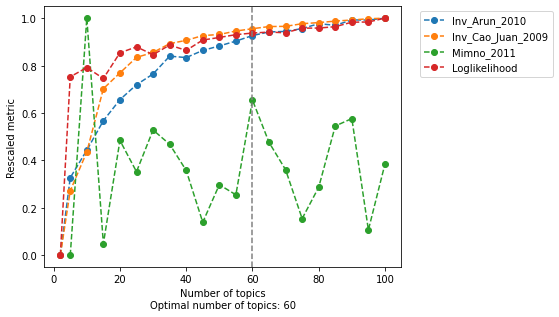

In [4]:
from pycisTopic.lda_models import *
model=evaluate_models(models,
                     select_model=60, 
                     return_model=True, 
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save= outDir + 'models/model_selection.pdf')

In [5]:
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

In [6]:
# Save
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 5. Visualize

In [1]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [4]:
cistopic_obj.selected_model.cell_topic_harmony.to_csv(outDir+'harmony_cell_topic.tsv', sep='\t')

In [8]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj,
                 target  = 'cell', scale=False)
run_tsne(cistopic_obj,
                 target  = 'cell', scale=False)

2022-02-18 11:14:04,190 cisTopic     INFO     Running UMAP
2022-02-18 11:14:35,098 cisTopic     INFO     Running FItSNE
Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 19485, K: 90, N*K = 1753650
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (36 threads):


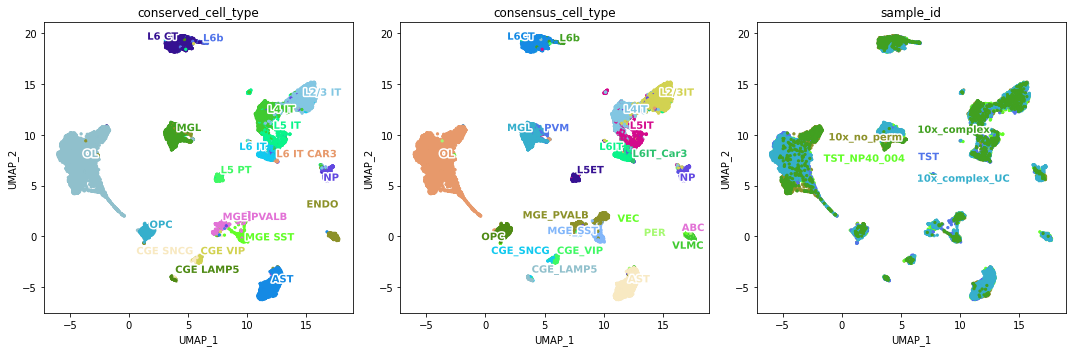

In [18]:
#os.mkdir(outDir + 'visualization/')
plot_metadata(cistopic_obj,
                 reduction_name='harmony_UMAP',
                 variables=['conserved_cell_type', 'consensus_cell_type', 'sample_id'], # Labels from RNA and new clusters
                 target='cell', num_columns=3,
                 text_size=10,
                 dot_size=5,
                 figsize=(15,5),
                 save= outDir + 'visualization/dimensionality_reduction_label_uncorrected.pdf')

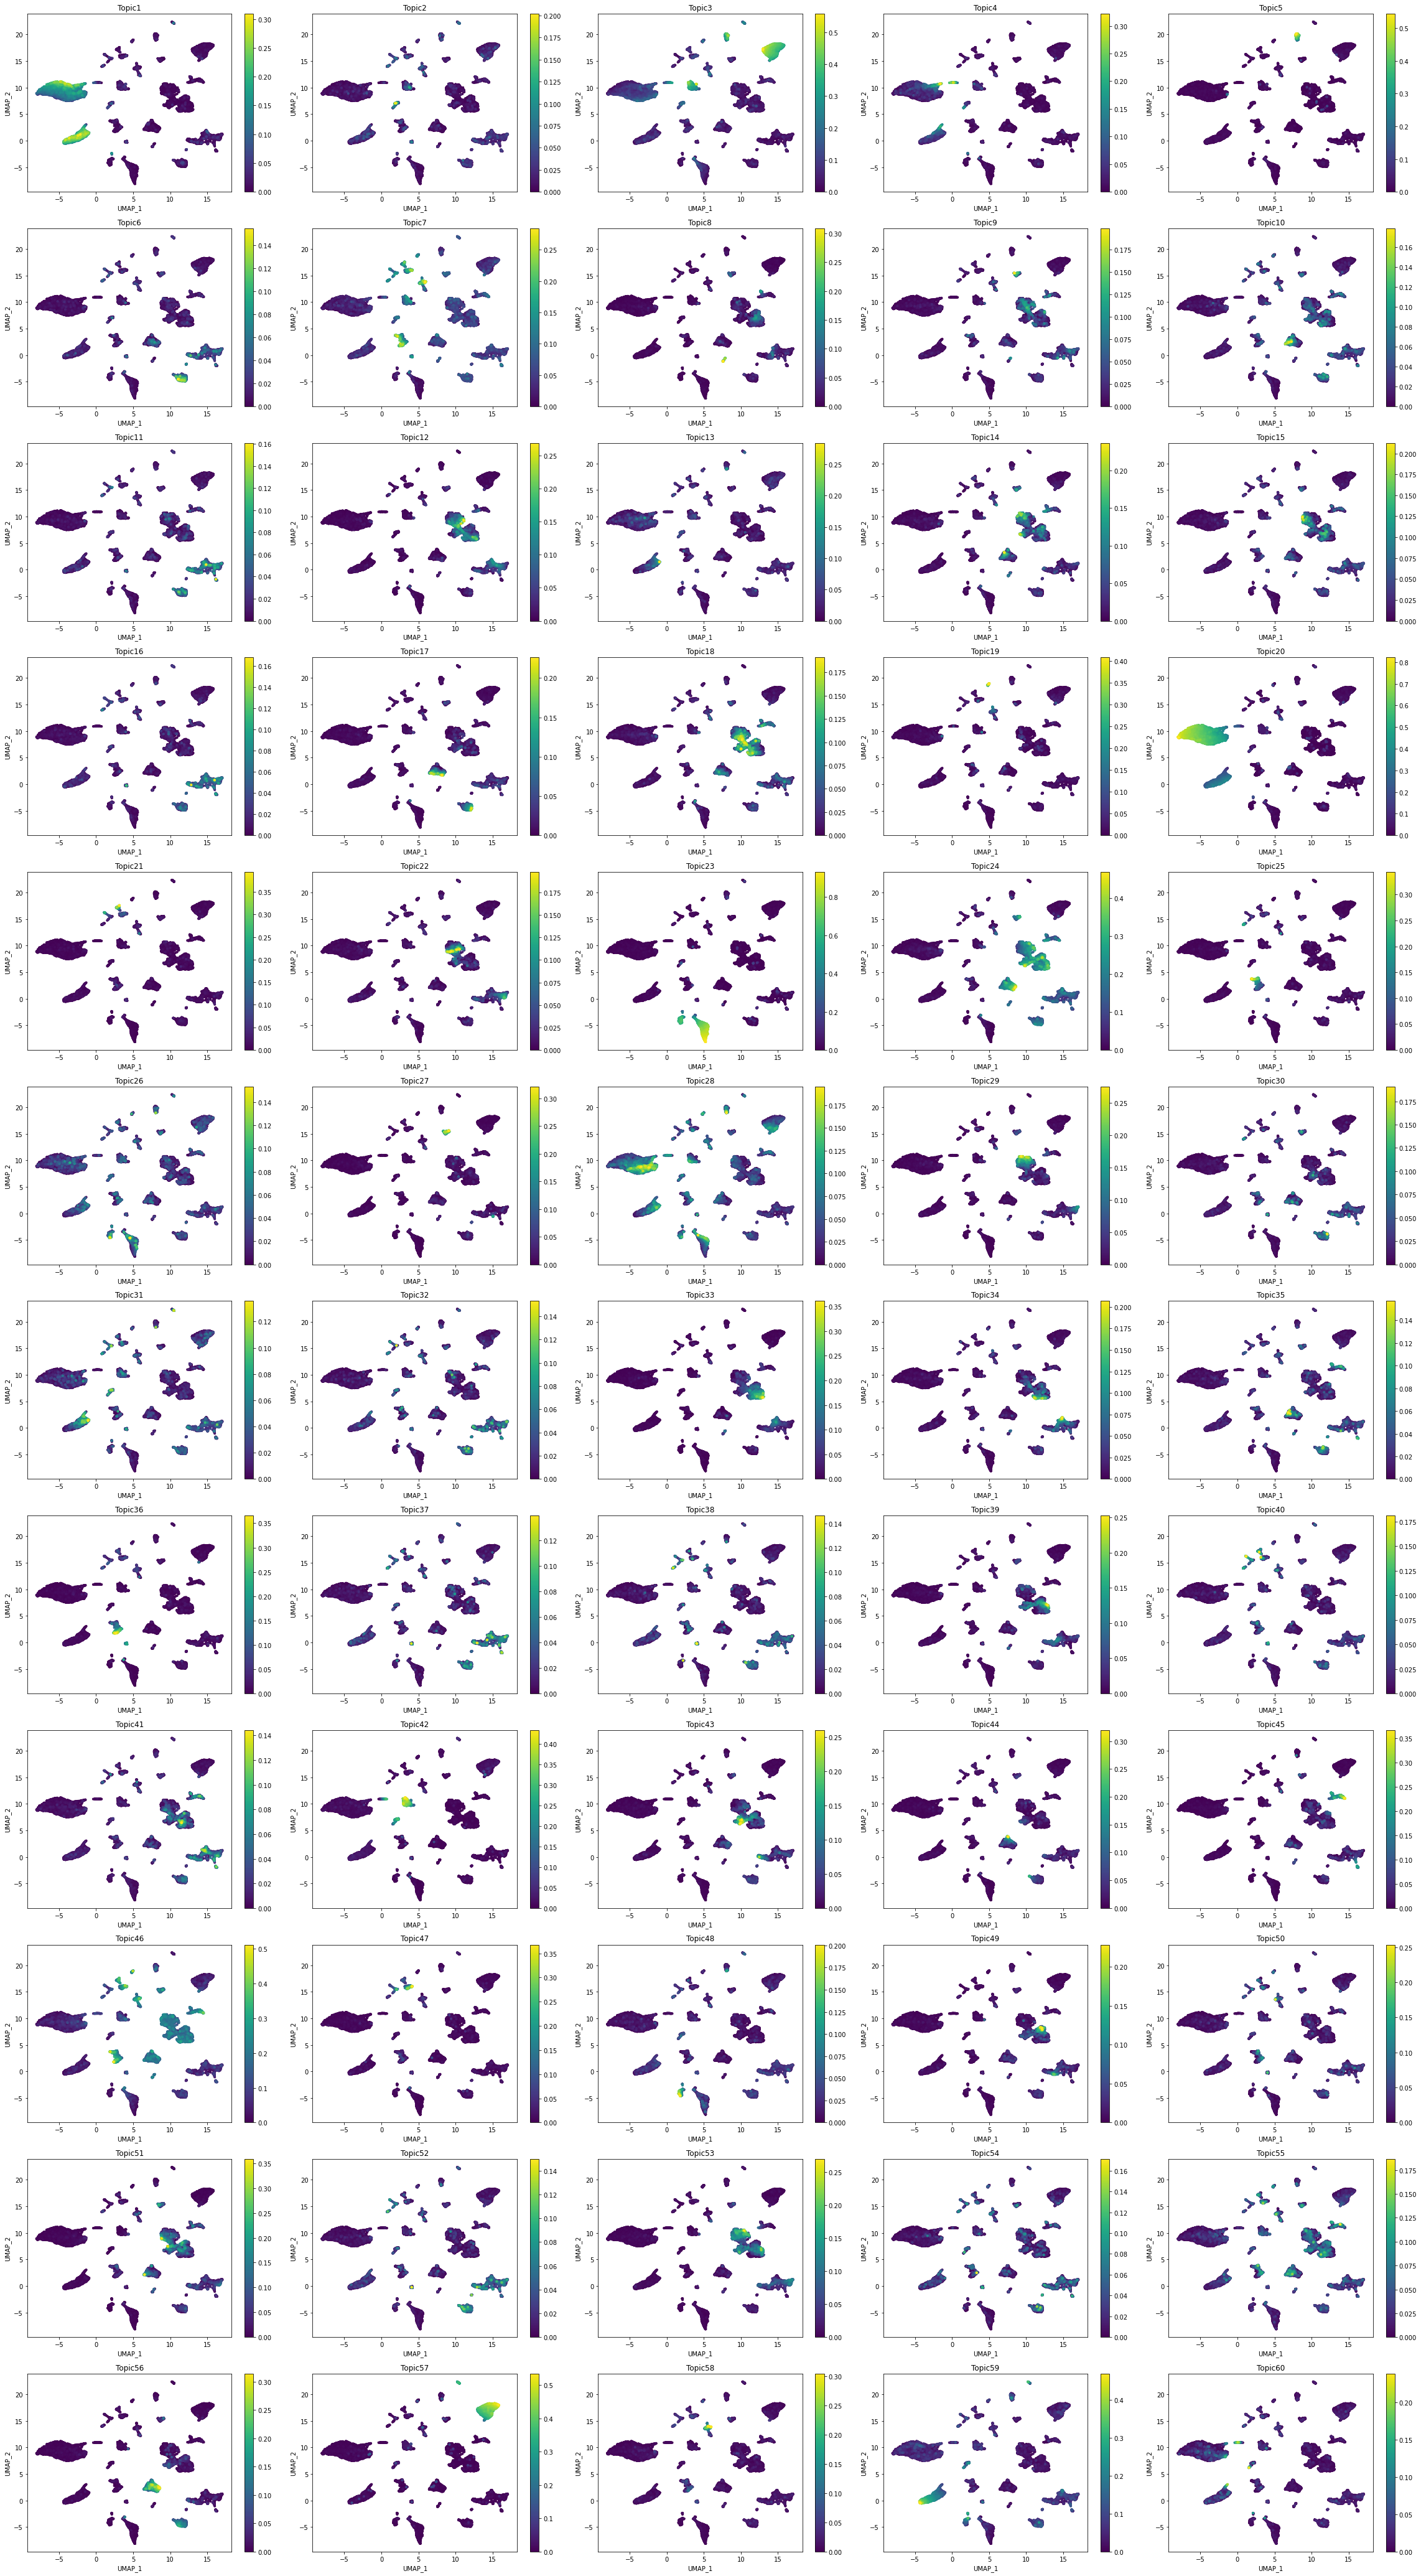

In [19]:
plot_topic(cistopic_obj,
            reduction_name = 'UMAP',
            target = 'cell',
            num_columns=5,
            save= outDir + 'visualization/dimensionality_reduction_topic_uncorrected.pdf')

In [11]:
# Harmony
harmony(cistopic_obj, 'sample_id', random_state=555)  
# UMAP
run_umap(cistopic_obj, reduction_name='harmony_UMAP',
                 target  = 'cell', harmony=True)
run_tsne(cistopic_obj, reduction_name='harmony_tSNE',
                 target  = 'cell', harmony=True)

2022-02-18 11:17:35,091 - harmonypy - INFO - Iteration 1 of 10


2022-02-18 11:17:35,091 harmonypy    INFO     Iteration 1 of 10


2022-02-18 11:17:43,948 - harmonypy - INFO - Iteration 2 of 10


2022-02-18 11:17:43,948 harmonypy    INFO     Iteration 2 of 10


2022-02-18 11:17:52,554 - harmonypy - INFO - Iteration 3 of 10


2022-02-18 11:17:52,554 harmonypy    INFO     Iteration 3 of 10


2022-02-18 11:17:57,998 - harmonypy - INFO - Converged after 3 iterations


2022-02-18 11:17:57,998 harmonypy    INFO     Converged after 3 iterations
2022-02-18 11:17:58,014 cisTopic     INFO     Running UMAP
2022-02-18 11:18:13,003 cisTopic     INFO     Running FItSNE


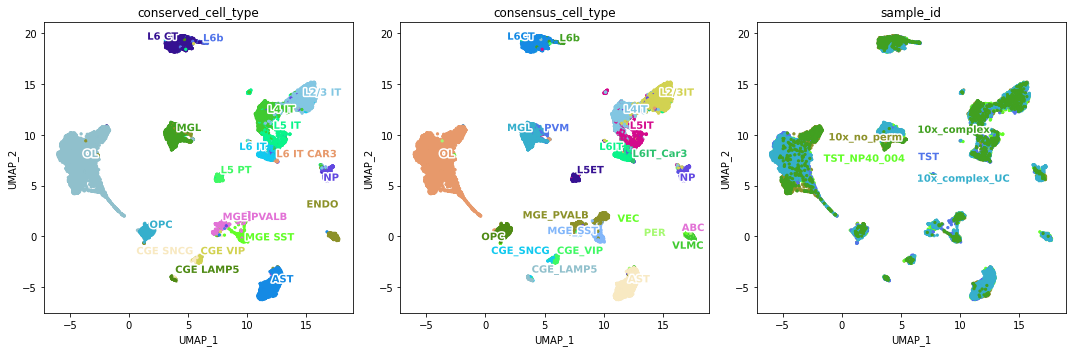

In [16]:
#os.mkdir(outDir + 'visualization/')
plot_metadata(cistopic_obj,
                 reduction_name='harmony_UMAP',
                 variables=['conserved_cell_type', 'consensus_cell_type', 'sample_id'], # Labels from RNA and new clusters
                 target='cell', num_columns=3,
                 text_size=10,
                 dot_size=5,
                 figsize=(15,5),
                 save= outDir + 'visualization/dimensionality_reduction_label_corrected.pdf')

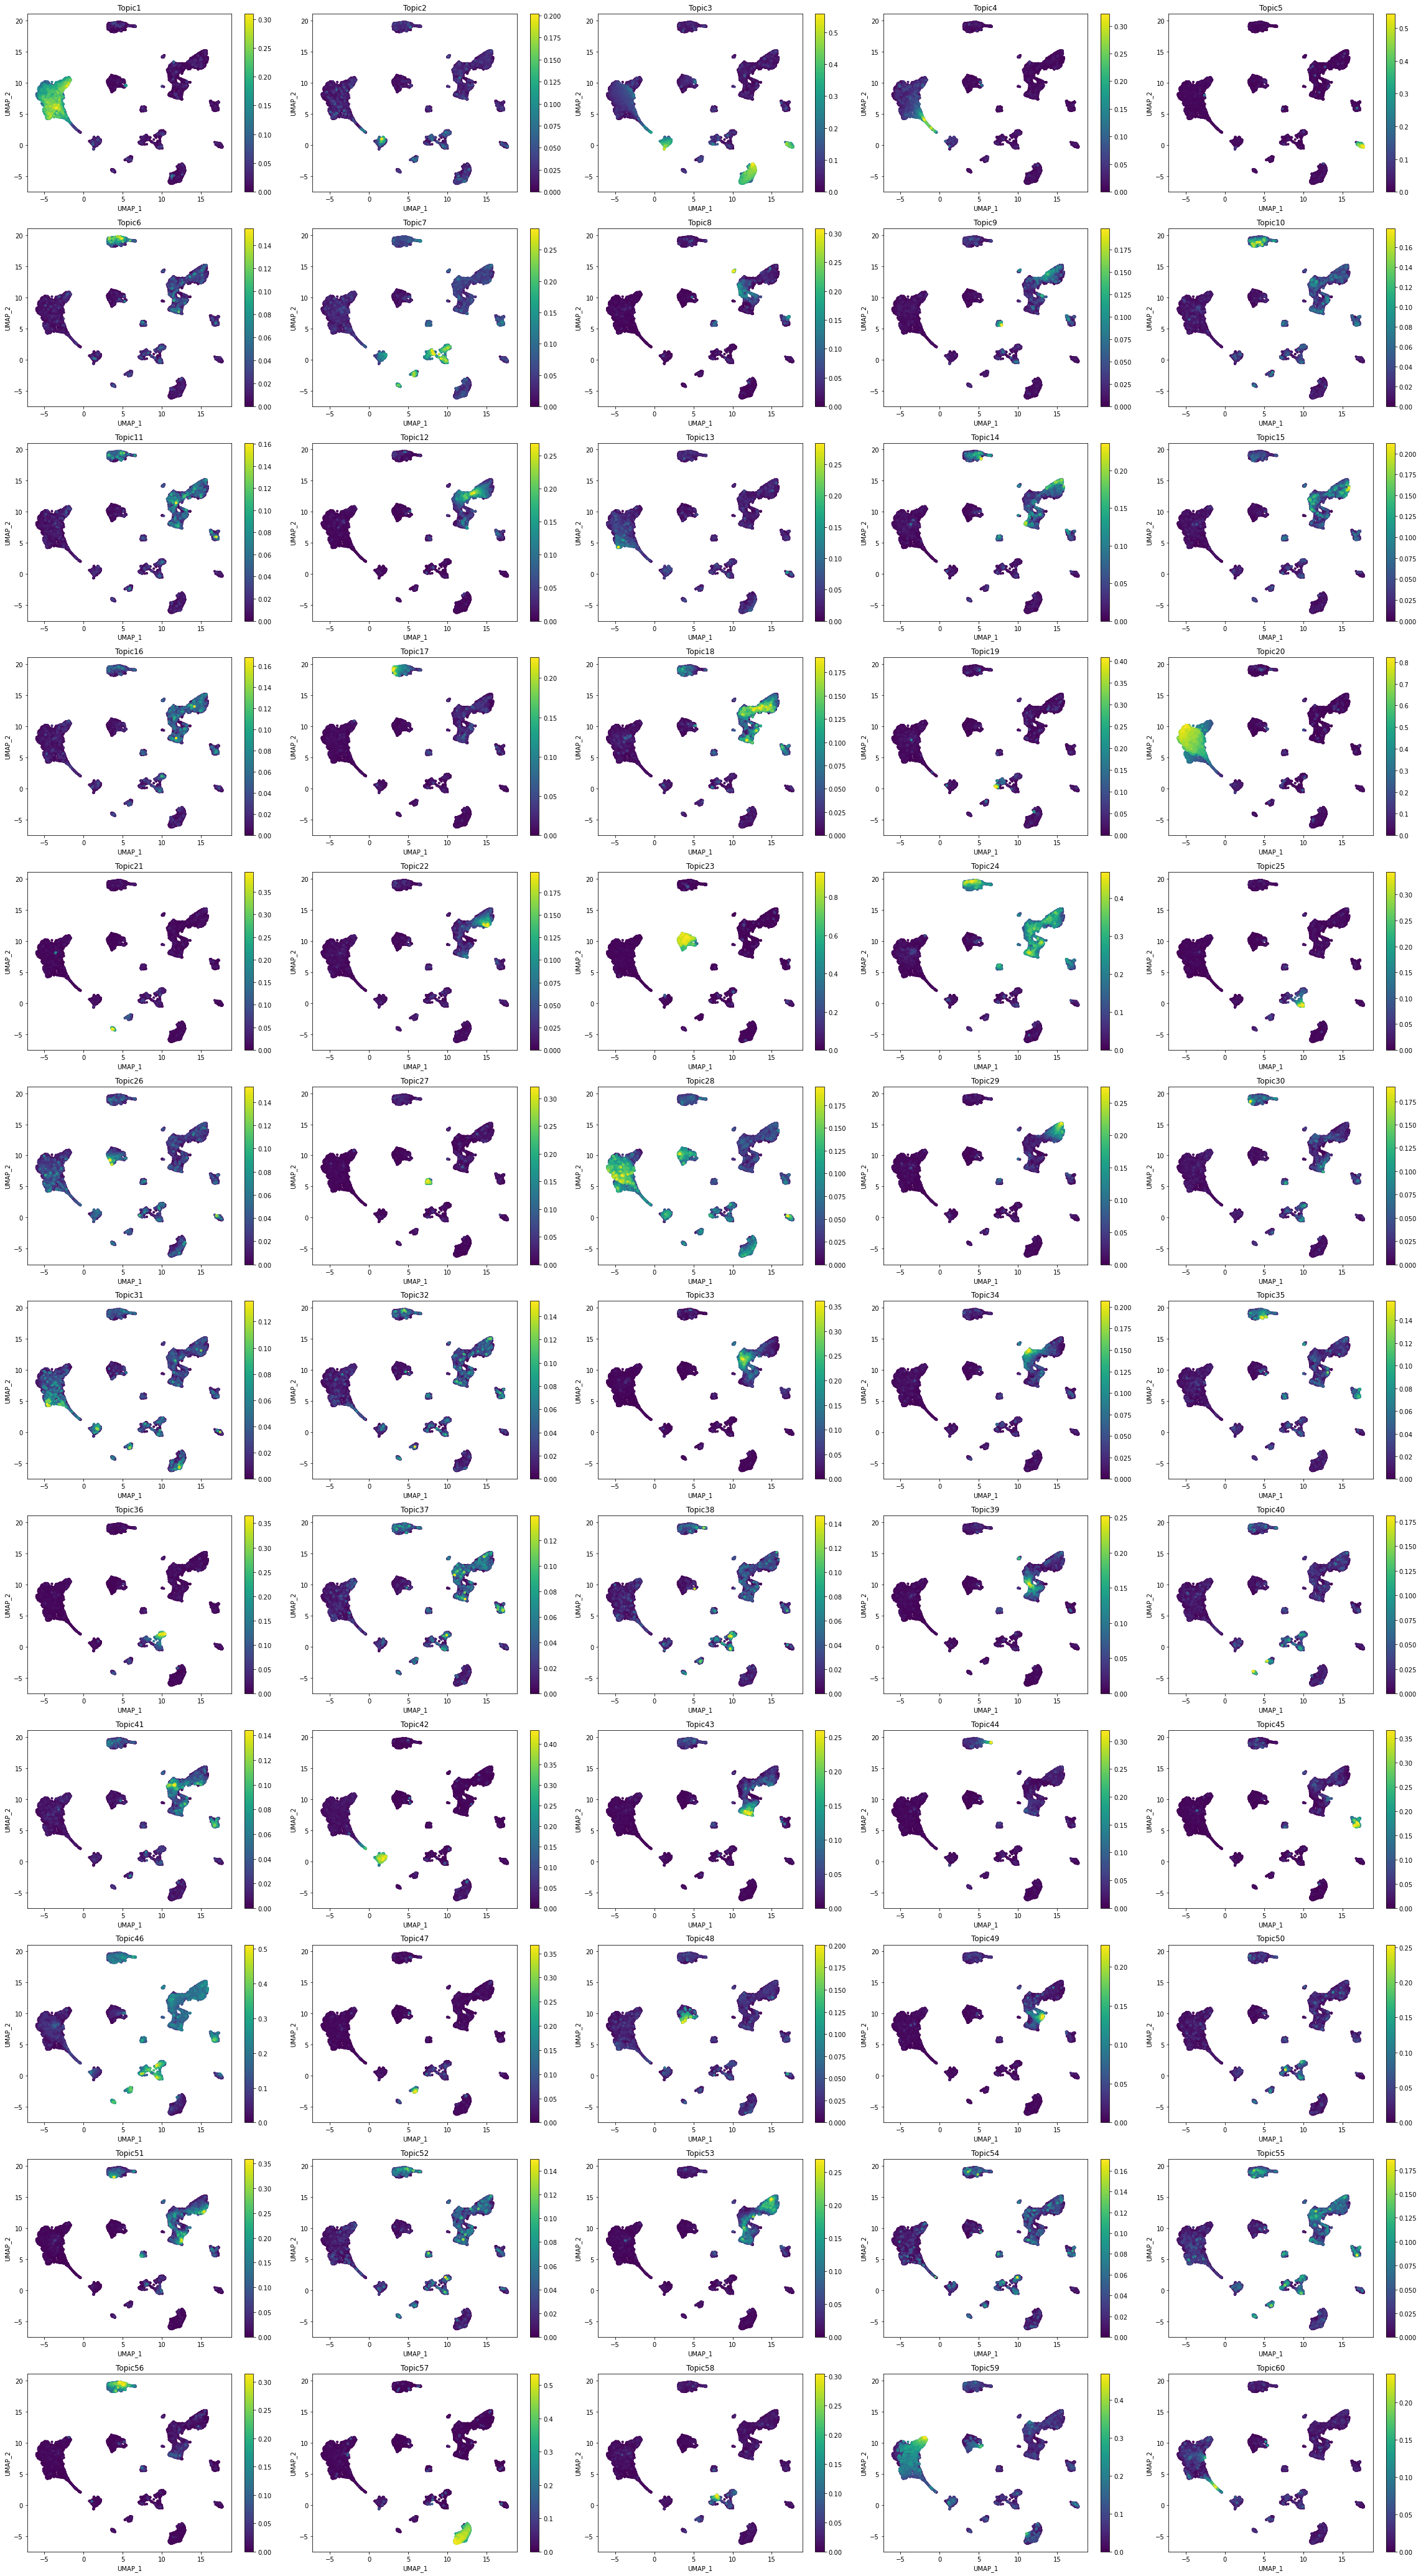

In [20]:
plot_topic(cistopic_obj,
            reduction_name = 'harmony_UMAP',
            target = 'cell',
            num_columns=5,
            save= outDir + 'visualization/dimensionality_reduction_topic_corrected.pdf')

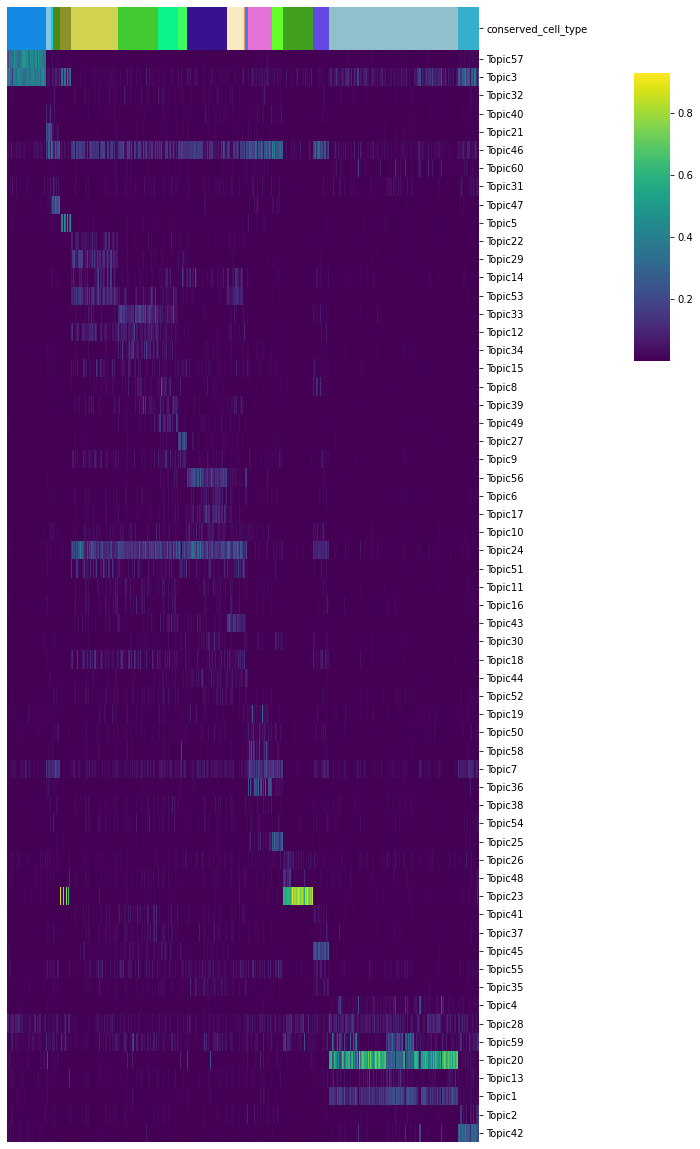

In [28]:
#from pycisTopic.clust_vis import *
cell_topic_heatmap(cistopic_obj,
                     variables = ['conserved_cell_type'],
                     scale = False,
                     legend_loc_x = 1.05,
                     legend_loc_y = -1.2,
                     legend_dist_y = -1,
                     figsize=(10,20),
                     save = outDir + 'visualization/heatmap_topic_contr.pdf')

In [29]:
# Save
with open(outDir + 'cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

## 6. Topic binarization

In [31]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, 
                                    method='otsu', 
                                    plot=False, 
                                    num_columns=5)
region_bin_topics_ntop3 = binarize_topics(cistopic_obj, 
                                    method='ntop', 
                                    ntop=3000,
                                    plot=False, 
                                    num_columns=5)
region_bin_topics_ntop6 = binarize_topics(cistopic_obj, 
                                    method='ntop', 
                                    ntop=6000,
                                    plot=False, 
                                    num_columns=5)

In [32]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=False, num_columns=5, nbins=100)

In [33]:
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [34]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

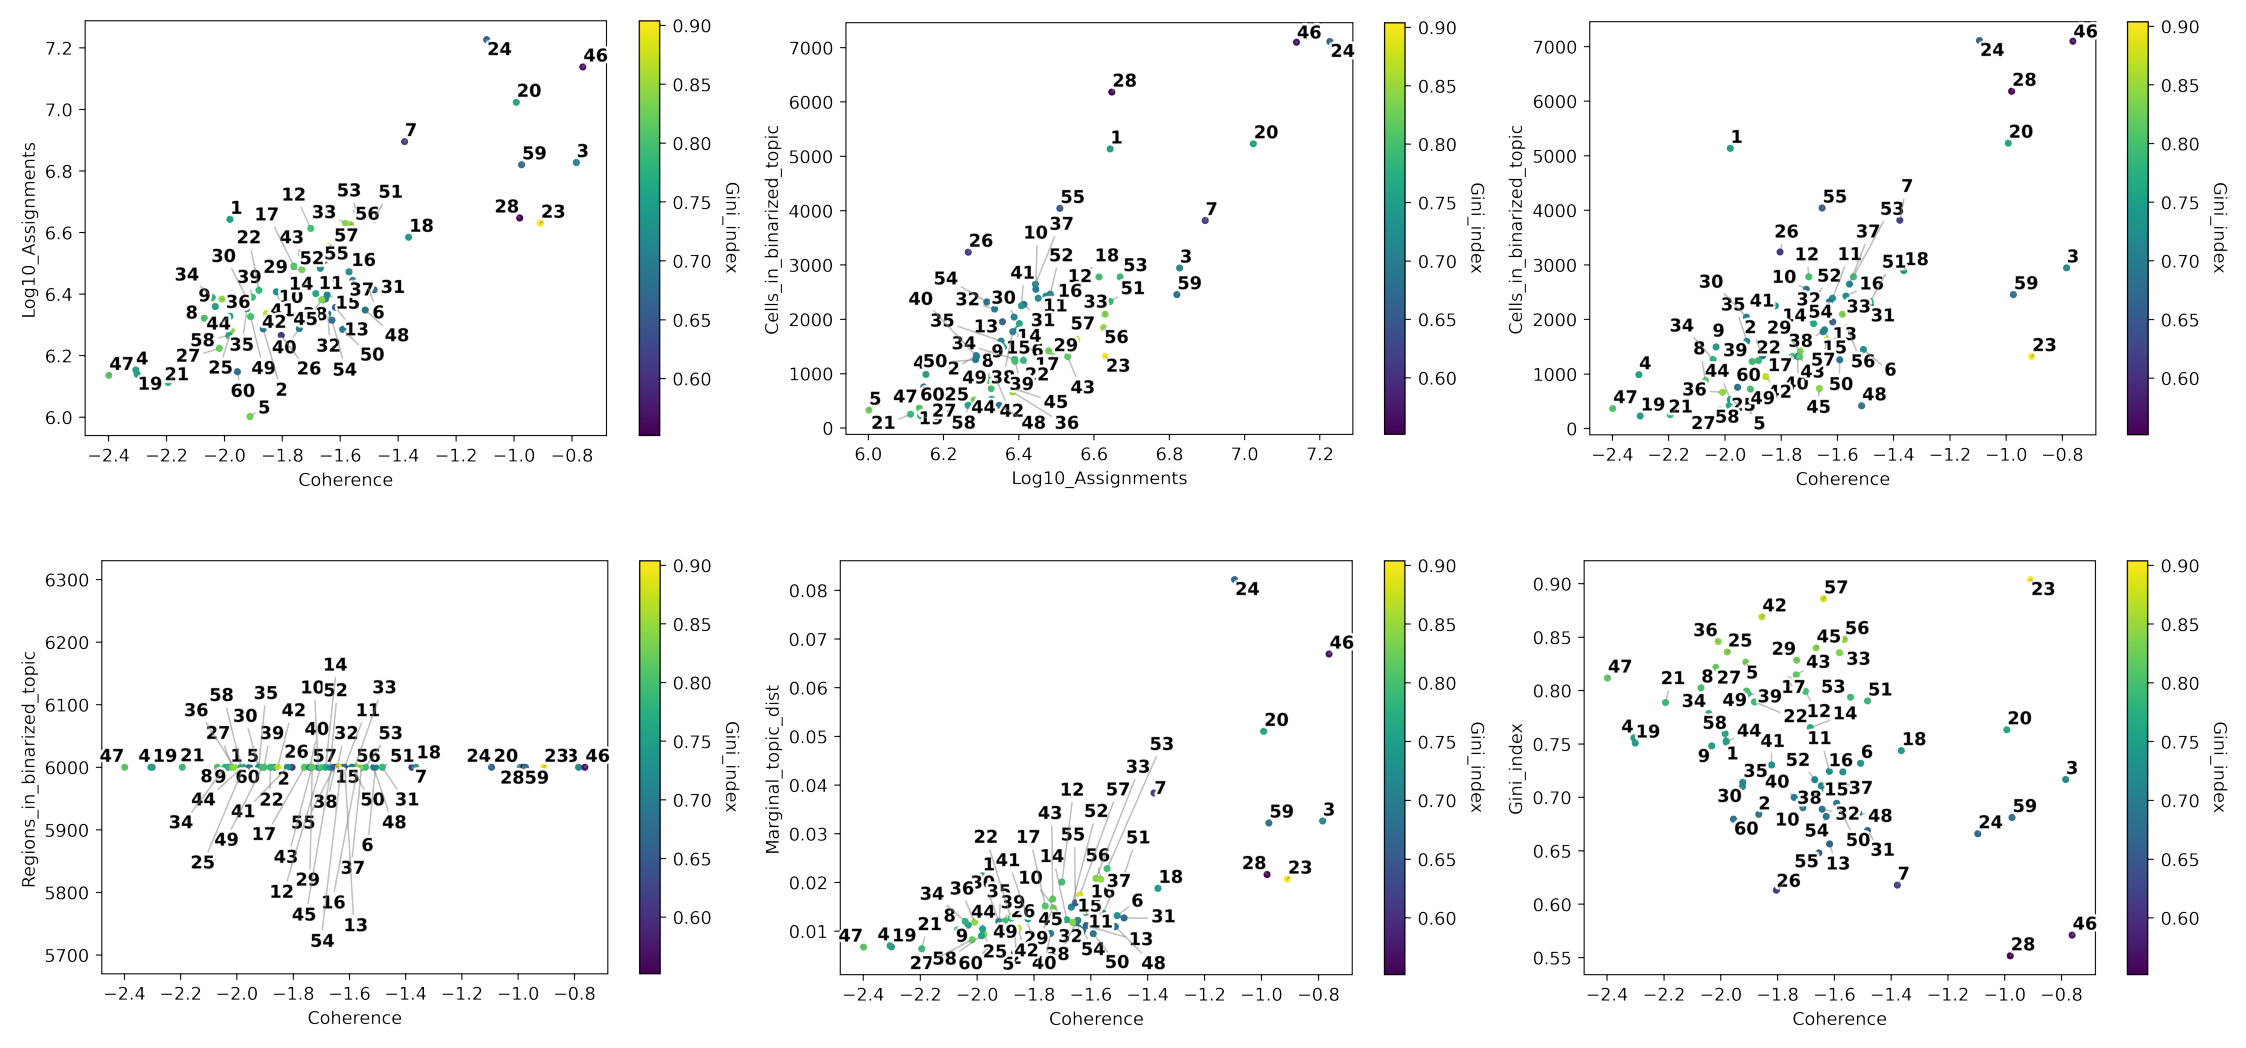

In [35]:
# Plot topic stats in one figure
os.mkdir(outDir + 'topic_binarization/')
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

In [36]:
# Save
with open(outDir + 'topic_binarization/Topic_qc_metrics.pkl', 'wb') as f:
  pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
  pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region_otsu.pkl', 'wb') as f:
  pickle.dump(region_bin_topics_otsu, f)
with open(outDir + 'topic_binarization/binarized_topic_region_3K.pkl', 'wb') as f:
  pickle.dump(region_bin_topics_ntop3, f)
with open(outDir + 'topic_binarization/binarized_topic_region_6K.pkl', 'wb') as f:
  pickle.dump(region_bin_topics_ntop6, f)

In [37]:
os.mkdir(outDir + 'topic_binarization/Otsu_bed')
os.mkdir(outDir + 'topic_binarization/3K_bed')
os.mkdir(outDir + 'topic_binarization/6K_bed')

for x in region_bin_topics_otsu.keys():
    pr.PyRanges(region_names_to_coordinates(region_bin_topics_otsu[x].index.tolist())).to_bed(path=outDir + 'topic_binarization/Otsu_bed/' + x + '.bed',
                                                                keep=True, compression='infer', chain=False)
for x in region_bin_topics_ntop3.keys():
    pr.PyRanges(region_names_to_coordinates(region_bin_topics_ntop3[x].index.tolist())).to_bed(path=outDir + 'topic_binarization/3K_bed/' + x + '.bed',
                                                                keep=True, compression='infer', chain=False)
    
for x in region_bin_topics_ntop6.keys():
    pr.PyRanges(region_names_to_coordinates(region_bin_topics_ntop6[x].index.tolist())).to_bed(path=outDir + 'topic_binarization/6K_bed/' + x + '.bed',
                                                                keep=True, compression='infer', chain=False)

/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a s

## 7. Differentially accessible regions (DARs)

In [4]:
# Load cisTopic object
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

In [38]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)

2022-02-18 11:55:42,802 cisTopic     INFO     Imputing drop-outs
2022-02-18 11:56:31,915 cisTopic     INFO     Scaling
2022-02-18 11:57:32,272 cisTopic     INFO     Keep non zero rows
2022-02-18 11:58:47,725 cisTopic     INFO     Imputed accessibility sparsity: 0.605450073496291
2022-02-18 11:58:47,729 cisTopic     INFO     Create CistopicImputedFeatures object
2022-02-18 11:58:47,729 cisTopic     INFO     Done!


In [39]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2022-02-18 12:04:03,749 cisTopic     INFO     Normalizing imputed data
2022-02-18 12:11:01,241 cisTopic     INFO     Done!


2022-02-18 12:11:12,702 cisTopic     INFO     Calculating mean
2022-02-18 12:12:00,646 cisTopic     INFO     Calculating variance


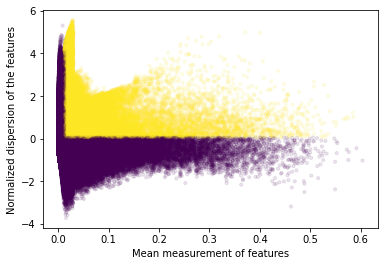

2022-02-18 12:15:35,224 cisTopic     INFO     Done!


In [41]:
os.mkdir(outDir + 'DARs/')
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125, 
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20, 
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

In [44]:
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='conserved_cell_type',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=1) 

2022-02-18 12:17:48,457 cisTopic     INFO     Formatting data for AST
2022-02-18 12:18:18,767 cisTopic     INFO     Computing p-value for AST
2022-02-18 12:20:47,804 cisTopic     INFO     Computing log2FC for AST
2022-02-18 12:20:52,877 cisTopic     INFO     AST done!
2022-02-18 12:20:53,470 cisTopic     INFO     Formatting data for CGE LAMP5
2022-02-18 12:21:27,887 cisTopic     INFO     Computing p-value for CGE LAMP5
2022-02-18 12:23:57,418 cisTopic     INFO     Computing log2FC for CGE LAMP5
2022-02-18 12:24:03,233 cisTopic     INFO     CGE LAMP5 done!
2022-02-18 12:24:03,846 cisTopic     INFO     Formatting data for CGE SNCG
2022-02-18 12:24:38,504 cisTopic     INFO     Computing p-value for CGE SNCG
2022-02-18 12:27:09,649 cisTopic     INFO     Computing log2FC for CGE SNCG
2022-02-18 12:27:14,674 cisTopic     INFO     CGE SNCG done!
2022-02-18 12:27:15,293 cisTopic     INFO     Formatting data for CGE VIP
2022-02-18 12:27:53,777 cisTopic     INFO     Computing p-value for CGE VIP

In [45]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

AST: 17241
CGE LAMP5: 10661
CGE SNCG: 9925
CGE VIP: 10515
ENDO: 14243
L2/3 IT: 34914
L4 IT: 35086
L5 IT: 37025
L5 PT: 27018
L6 CT: 28765
L6 IT: 34548
L6 IT CAR3: 31363
L6b: 20292
MGE PVALB: 11044
MGE SST: 11735
MGL: 14600
NP: 22073
OL: 23824
OPC: 13326


In [46]:
# Save
with open(outDir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
  pickle.dump(imputed_acc_obj, f)
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

In [49]:
# Export DARs to tsv
DARs_dict = {re.sub('[^A-Za-z0-9]+', '_', key): markers_dict[key] for key in markers_dict.keys()}
#os.mkdir(outDir + 'DARs/DARs_tsv/')
for x in DARs_dict.keys():
    DARs_dict[x].to_csv(outDir + 'DARs/DARs_tsv/'+x+'.tsv', sep='\t')
    
os.mkdir(outDir + 'DARs/DARs_bed/') 
for x in DARs_dict.keys():
    pr.PyRanges(region_names_to_coordinates(DARs_dict[x].index.tolist())).to_bed(path=outDir + 'DARs/DARs_bed/' + x + '.bed',
                                                                    keep=True, compression='infer', chain=False)
    
os.mkdir(outDir + 'DARs/DARs_bed_3K/') 
for x in DARs_dict.keys():
    pr.PyRanges(region_names_to_coordinates(DARs_dict[x].index.tolist()[0:3000])).to_bed(path=outDir + 'DARs/DARs_bed_3K/' + x + '.bed',
                                                                    keep=True, compression='infer', chain=False)
os.mkdir(outDir + 'DARs/DARs_bed_6K/') 
for x in DARs_dict.keys():
    pr.PyRanges(region_names_to_coordinates(DARs_dict[x].index.tolist()[0:6000])).to_bed(path=outDir + 'DARs/DARs_bed_6K/' + x + '.bed',
                                                                    keep=True, compression='infer', chain=False)

/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return pd.concat([outdf, df.get(noncanonical)], axis=1)
/opt/venv/lib/python3.8/site-packages/pyranges/out.py:37: FutureWarning: Passing a s

## 8. Export to loom

In [51]:
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
# Load cisTopic object
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
imputed_acc_obj = pickle.load(infile)
infile.close()
# Load region binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region_otsu.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
binarized_topic_region = pickle.load(infile)
infile.close()
# Load cell binarized topics
import pickle
infile = open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
binarized_cell_topic = pickle.load(infile)
infile.close()
# Load DARs
import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

In [75]:
# Format coordinate system
projDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/'
from loomxpy.loomxpy import SCopeLoom
path_to_annotated_rna_loom = projDir + 'data/MO_GEX_seurat_Cortex.loom'
loom = SCopeLoom.read_loom(path_to_annotated_rna_loom)
rna_embeddings = {key: loom.embeddings[key].get_embedding() for key in loom.embeddings.keys()}
rna_embeddings.keys()

dict_keys(['VSN UMAP', 'VSN TSNE', 'Seurat Harmony UMAP', 'Seurat Harmony tSNE', 'Seurat UMAP', 'Seurat tSNE'])

In [70]:
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
cell_data = get_metadata(loom)
cell_data = cell_data.replace('TEW__c14e1d__Multiome_RNA_brain_10x_no_perm', '10x_no_perm')
cell_data = cell_data.replace('TEW__3cc0d9__bb22bc__Multiome_brain_TST_NP40_004', 'TST_NP40_004')
cell_data = cell_data.replace('TEW__75da5c__5b0f59__Multiome_brain_TST', 'TST')
cell_data = cell_data.replace('TEW__c3f7c1__1ac906__Multiome_brain_10xcomplex_UC', '10x_complex_UC')
cell_data = cell_data.replace('TEW__d112c8__547ada__Multiome_RNA_brain_10x_complex', '10x_complex')

In [71]:
cell_data['barcode'] = [x.split('___')[0] for x in cell_data.index.tolist()]
cell_data.index = cell_data['barcode'] + '___' + cell_data['sample_id']

In [72]:
for key in rna_embeddings.keys():
    rna_embeddings[key].index = cell_data.index
    rna_embeddings[key] = rna_embeddings[key].loc[cistopic_obj.cell_names,]

In [73]:
# Function
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [74]:
cistopic_obj.projections['cell'] = merge_two_dicts(cistopic_obj.projections['cell'], rna_embeddings)
cistopic_obj.projections['cell']['pycisTopic UMAP'] = cistopic_obj.projections['cell'].pop('UMAP')
cistopic_obj.projections['cell']['pycisTopic tSNE'] = cistopic_obj.projections['cell'].pop('tSNE')
cistopic_obj.projections['cell']['pycisTopic Harmony UMAP'] = cistopic_obj.projections['cell'].pop('harmony_UMAP')
cistopic_obj.projections['cell']['pycisTopic Harmony tSNE'] = cistopic_obj.projections['cell'].pop('harmony_tSNE')
cistopic_obj.projections['cell'].keys()

dict_keys(['VSN UMAP', 'VSN TSNE', 'Seurat Harmony UMAP', 'Seurat Harmony tSNE', 'Seurat UMAP', 'Seurat tSNE', 'pycisTopic UMAP', 'pycisTopic tSNE', 'pycisTopic Harmony UMAP', 'pycisTopic Harmony tSNE'])

In [22]:
# Prepare DARs dict
#os.mkdir(outDir + 'loom')
cluster_markers = {'conserved_cell_type': DARs_dict}
# Export to loom
from pycisTopic.loom import *
export_region_accessibility_to_loom(accessibility_matrix = imputed_acc_obj,
                  cistopic_obj = cistopic_obj, 
                  binarized_topic_region = binarized_topic_region,
                  binarized_cell_topic = binarized_cell_topic,
                  out_fname = outDir + 'loom/pycisTopic_region_accessibility.loom',
                  cluster_annotation = ['conserved_cell_type'],
                  cluster_markers = cluster_markers,
                  tree_structure = ('Mouse_cortex_TEW', 'atac', 'pycisTopic'),
                  title = 'Region accessibility all',
                  nomenclature = "mm10")   

2022-01-10 18:44:50,289 cisTopic     INFO     Creating minimal loom
2022-01-10 18:48:11,709 cisTopic     INFO     Adding annotations
2022-01-10 18:49:08,129 cisTopic     INFO     Adding clusterings
2022-01-10 18:49:08,170 cisTopic     INFO     Adding markers
2022-01-10 18:49:17,785 cisTopic     INFO     Exporting


## 9. Compute DARs between neuronal groups only

In [2]:
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
# Load cisTopic object
import pickle
infile = open(outDir + 'cisTopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()
# Load imputed accessibility
import pickle
infile = open(outDir + 'DARs/Imputed_accessibility.pkl', 'rb') #Here I am using pycisTopic gene activity matrix, but could be any :)
imputed_acc_obj = pickle.load(infile)
infile.close()

In [11]:
# Subset only neuronal cell types
neurons = ['CGE LAMP5', 'CGE SNCG', 'CGE VIP', 'L2/3 IT', 'L4 IT', 'L5 IT', 'L5 PT', 'L6 CT', 'L6 IT',  'L6 IT CAR3', 'L6b', 'MGE PVALB', 'MGE SST', 'NP']
neuron_cells = [x for x in cistopic_obj.cell_data.index.tolist() if cistopic_obj.cell_data.loc[x,'conserved_cell_type'] in neurons]

In [13]:
imputed_acc_obj.subset(cells=neuron_cells)

CistopicImputedFeatures from project cisTopic_Impute with nCells × nFeatures = 19485 × 568342


In [ ]:
from pycisTopic.diff_features import *
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125, 
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20, 
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot_only_neurons.pdf')

In [ ]:
markers_dict= find_diff_features(cistopic_obj, 
                      imputed_acc_obj,
                      variable='conserved_cell_type',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=1) 

In [14]:
x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

NameError: name 'markers_dict' is not defined

In [ ]:
with open(outDir + 'DARs/DARs_only_neurons.pkl', 'wb') as f:
  pickle.dump(markers_dict, f)

In [ ]:
# Run cistarget for neuron DARs
outDir = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycisTopic/'
import pickle
infile = open(outDir+'DARs/DARs_only_neurons.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()
# Format region sets
import re
import pyranges as pr
from pycistarget.utils import *
region_sets = {}
region_sets['DARs_neurons'] = {re.sub('[^A-Za-z0-9]+', '_', key): pr.PyRanges(region_names_to_coordinates(DARs_dict[key].index.tolist())) for key in DARs_dict.keys()}

In [ ]:
# Run pycistarget
# run_without_promoters = True, will run the methods in all regions + the region sets without promoters
import os
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/')
from scenicplus.wrappers.run_pycistarget import *
run_pycistarget(region_sets,
                 ctx_db_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/ctx_db/TEW_mouse_cortex.regions_vs_motifs.rankings.feather',
                 species = 'mus_musculus',
                 save_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycistarget_clustered_data_set_specific/',
                 dem_db_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/ctx_db/TEW_mouse_cortex.regions_vs_motifs.scores.feather',
                 run_without_promoters = True,
                 biomart_host = 'http://nov2020.archive.ensembl.org/',
                 promoter_space = 500,
                 ctx_auc_threshold = 0.005,
                 ctx_nes_threshold = 3.0,
                 ctx_rank_threshold = 0.05,
                 dem_log2fc_thr = 0.5,
                 dem_motif_hit_thr = 3.0,
                 dem_max_bg_regions = 500,
                 path_to_motif_annotations = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/snapshots/motifs-v10-nr.mgi-m0.001-o0.0_clust.tsv',
                 annotation_version = 'v10nr_clust',
                 annotation = ['Direct_annot', 'Orthology_annot'],
                 n_cpu = 1,
                 _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                 exclude_motifs = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/Promoter_bias/clustered/Promoter_motifs.tsv')
# Output in /staging/leuven/stg_00002/lcb/cbravo/EAD_v2/pycistarget/menr.pkl, directly usable in SCENIC+ object

In [ ]:
# Run pycistarget
# run_without_promoters = True, will run the methods in all regions + the region sets without promoters
import os
os.chdir('/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/scenicplus/src/')
from scenicplus.wrappers.run_pycistarget import *
run_pycistarget(region_sets,
                 ctx_db_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/ctx_db/TEW_mouse_cortex.regions_vs_motifs.rankings.feather',
                 species = 'mus_musculus',
                 save_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/TEW_cortex/pycistarget_clustered_data_set_specific/',
                 dem_db_path = '/staging/leuven/stg_00002/lcb/cbravo/Multiomics_pipeline/analysis/10x_multiome_mouse_cortex/ctx_db/TEW_mouse_cortex.regions_vs_motifs.scores.feather',
                 run_without_promoters = True,
                 biomart_host = 'http://nov2020.archive.ensembl.org/',
                 promoter_space = 500,
                 ctx_auc_threshold = 0.005,
                 ctx_nes_threshold = 3.0,
                 ctx_rank_threshold = 0.05,
                 dem_log2fc_thr = 0.5,
                 dem_motif_hit_thr = 3.0,
                 dem_max_bg_regions = 500,
                 path_to_motif_annotations = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/snapshots/motifs-v10-nr.mgi-m0.001-o0.0_clust.tsv',
                 annotation_version = 'v10nr_clust',
                 annotation = ['Direct_annot', 'Motif_similarity_annot', 'Orthology_annot', 'Motif_similarity_and_Orthology_annot'],
                 motif_similarity_fdr = 0.000001,
                 n_cpu = 1,
                 _temp_dir = '/scratch/leuven/313/vsc31305/ray_spill',
                 exclude_motifs = '/staging/leuven/stg_00002/lcb/cbravo/cluster_motif_collection_V10/Promoter_bias/clustered/Promoter_motifs.tsv')
# Output in /staging/leuven/stg_00002/lcb/cbravo/EAD_v2/pycistarget/menr.pkl, directly usable in SCENIC+ object